## New Fitting Tools (5/26/17)

The development branch provides a rewrite of the fitting tools with the goal of defining a single redshift fitting algorithm whether or not you're fitting the `multifit.MultiBeam` or `stack.StackFitter` objects.  Fitting the drizzled spectra is generally the fastest, and is *much* faster when many individual beam extractions are available for a given object.  For example, sources in the HUDF area can contain as many as 180 individual beams from FIGS, 3D-HST and archival observations, and fitting on the `multifit.MultiBeam` object can take minutes or even hours per source.  However, the full WCS information is only preserved for the `multifit.MultiBeam` objects, so these must be used to drizzle the continuum-subtracted, rectified emission line maps.  

Also implemented are now more compact data formats for storing all of the outputs of a given source that can be easily distributed without having to provide all of the original FLT files.  The `multifit.MultiBeam` object now knows how to read/write a single file (`*beams.fits`) that contains all of the information necessary for performing the fitting analysis.  

#### The `fitting.GroupFitter` object can also incorporate broad-band photometry in the redshift fit, though this will be documented at a later time.

In [1]:
%matplotlib inline

In [2]:
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import drizzlepac

import grizli
import grizli.stack

No TEAL-based tasks available for this package!
The following task in the fitsblender package can be run with TEAL:
                                  blendheaders                                  
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


In [3]:
# Initialize the GroupFLT object we computed with WFC3IR_Reduction
grp = grizli.multifit.GroupFLT(grism_files=glob.glob('*.0?.GrismFLT.fits'), direct_files=[], 
              ref_file='../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits',
              seg_file='../Catalog/ERS_GOODS-S_IR.seg.fits',
              catalog='../Catalog/ERS_GOODS-S_IR.cat',
              cpu_count=8)

Load ib6o21qmq.01.GrismFLT.fits!
Load ib6o21qoq.01.GrismFLT.fits!
Load ib6o21r6q.01.GrismFLT.fits!
Load ib6o21r8q.01.GrismFLT.fits!
Load ib6o23rsq.01.GrismFLT.fits!
Load ib6o23ruq.01.GrismFLT.fits!
Load ib6o23ryq.01.GrismFLT.fits!
Load ib6o23s0q.01.GrismFLT.fits!
Files loaded - 4.60 sec.


In [4]:
# Extract an object
TARGET = 'ers-grism'
fcontam = 0.2

id = 40776

ers-grism_40776.beams.fits


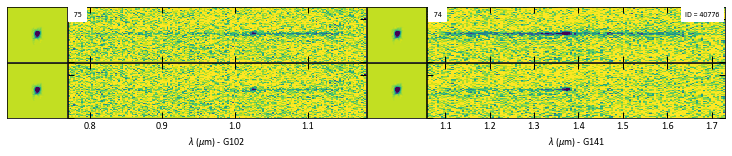

In [5]:
beams = grp.get_beams(id, size=32)
mb = grizli.multifit.MultiBeam(beams, fcontam=fcontam, group_name=TARGET)

# Make drizzled spectra
hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=fcontam, flambda=False, size=32, scale=1., kernel='point')
fig.savefig('{0}_{1:05d}.stack.png'.format(TARGET, id))
hdu.writeto('{0}_{1:05d}.stack.fits'.format(TARGET, id), clobber=True)

# Save beam extractions
mb.write_master_fits()

In [6]:
### Initialize templates

# Line complexes for redshift fits
t0 = grizli.utils.load_templates(fwhm=1200, line_complexes=True, fsps_templates=True)  
# Continuum + individual line templates
t1 = grizli.utils.load_templates(fwhm=1200, line_complexes=False, fsps_templates=True)
#  Line drizzle parameters
pline = {'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}

### Fit the individual extractions

Redshift fit: 17.5 s, Template fit: 1.1 s


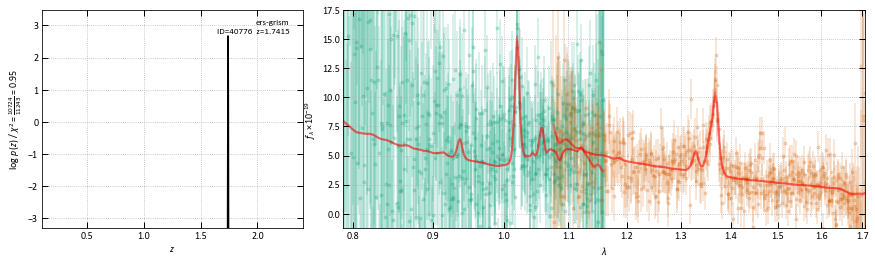

In [7]:
# Redshift fit
m0 = time.time()
fit = mb.xfit_redshift(templates=t0, zr=[0.1, 2.4], dz=[0.004, 0.0005], prior=None, fitter='nnls', verbose=False)

m1 = time.time()

# Best-fit template
tfit = mb.template_at_z(z=fit.meta['z_risk'][0], templates=t1, fit_background=True, fitter='nnls')
m2 = time.time()

fig = mb.xmake_fit_plot(fit, tfit)

print('Redshift fit: {0:.1f} s, Template fit: {1:.1f} s'.format(m1-m0, m2-m1))

### Fit the drizzled spectrum

In [8]:
st = grizli.stack.StackFitter(files='{0}_{1:05d}.stack.fits'.format(TARGET, id), group_name=TARGET, 
                              sys_err=0.02, mask_min=0.1, fit_stacks=False, fcontam=fcontam,
                              pas=None, extensions=None, min_ivar=0.01, overlap_threshold=3, verbose=True)

# Available extensions
print('Extensions: ', st.ext)

Load file ers-grism_40776.stack.fits
Mask 0 additional pixels for ext G102,75.0
Mask 0 additional pixels for ext G141,74.0
Extensions:  ['G102,75.0', 'G141,74.0']


Redshift fit: 5.8 s, Template fit: 1.0 s


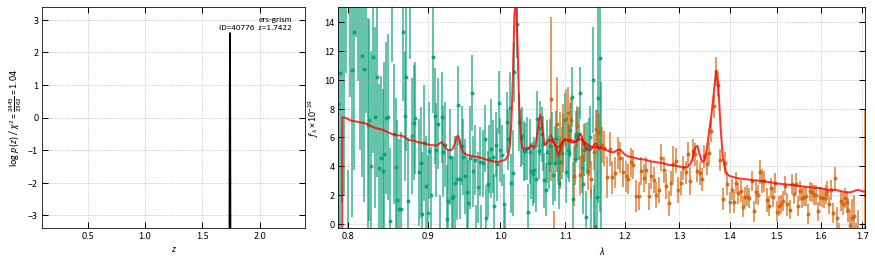

In [9]:
# Redshift fit, code is identical
m0 = time.time()
fit = st.xfit_redshift(templates=t0, zr=[0.1, 2.4], dz=[0.004, 0.0005], prior=None, fitter='nnls', verbose=False)

m1 = time.time()

# Best-fit template
tfit = st.template_at_z(z=fit.meta['z_risk'][0], templates=t1, fit_background=True, fitter='nnls')
m2 = time.time()

fig = st.xmake_fit_plot(fit, tfit)

print('Redshift fit: {0:.1f} s, Template fit: {1:.1f} s'.format(m1-m0, m2-m1))

### Wrapper script

Fit the drizzled spectra first (fast) and then the individual spectra near the best redshift.

Load file ers-grism_40776.stack.fits
Mask 0 additional pixels for ext G102,75.0
Mask 0 additional pixels for ext G141,74.0
1 ib6o21qmq_flt.fits G102
2 ib6o21qoq_flt.fits G102
3 ib6o21r6q_flt.fits G102
4 ib6o21r8q_flt.fits G102
5 ib6o23rsq_flt.fits G141
6 ib6o23ruq_flt.fits G141
7 ib6o23ryq_flt.fits G141
8 ib6o23s0q_flt.fits G141
Load file ers-grism_40776.stack.fits
Drizzle line -> OIII (14.83 0.98)
Drizzle line -> Hb   (3.41 0.82)
Drizzle line -> OII  (9.64 1.11)
Run time: 13.8 s


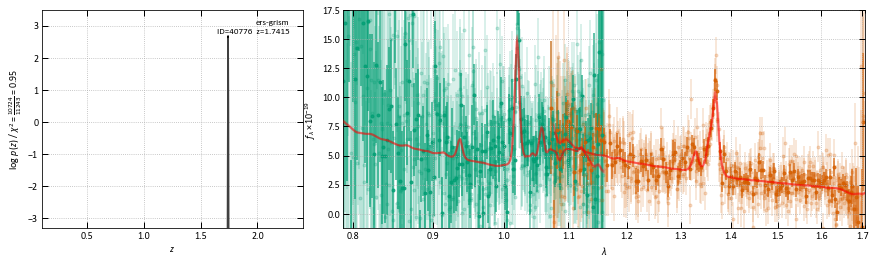

In [10]:
### Wrapper script to fit the drizzle spectra first (fast) and then the individual spectra near the best redshift
m0 = time.time()

pline['pixscale'] = 0.1
out = grizli.fitting.run_all(id, t0=t0, t1=t1, fwhm=1200, zr=[0.1, 2.4], dz=[0.004, 0.0005], fitter='nnls', 
                       group_name=TARGET, fit_stacks=False, prior=None, fcontam=0.2, pline=pline, mask_sn_limit=3, 
                       fit_beams=True, root=TARGET, fit_trace_shift=False, phot=None, verbose=False)

mb, st, fit, tfit, line_hdu = out

m1 = time.time()
print('Run time: {0:.1f} s'.format(m1-m0))

In [11]:
# Output files
ls_str = 'ls -lth {0}_{1:05d}* > lsr; cat lsr'.format(TARGET, id)
os.system(ls_str)
!cat lsr

-rw-r--r--  1 brammer  STSCI\science   1.8M May 26 15:28 ers-grism_40776.full.fits
-rw-r--r--@ 1 brammer  STSCI\science   108K May 26 15:28 ers-grism_40776.full.png
-rw-r--r--  1 brammer  STSCI\science   2.9M May 26 15:27 ers-grism_40776.beams.fits
-rw-r--r--  1 brammer  STSCI\science   703K May 26 15:27 ers-grism_40776.stack.fits
-rw-r--r--@ 1 brammer  STSCI\science   103K May 26 15:27 ers-grism_40776.stack.png
-rw-r--r--@ 1 brammer  STSCI\science    23K May 26 15:16 ers-grism_40776.line.png


ers-grism_40776.beams.fits


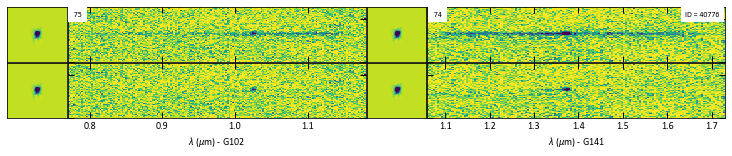

In [12]:
# Redrizzle with better continuum model
hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=fcontam, flambda=False, size=32, scale=1., kernel='point', zfit=tfit)
fig.savefig('{0}_{1:05d}.stack.png'.format(TARGET, id))
hdu.writeto('{0}_{1:05d}.stack.fits'.format(TARGET, id), clobber=True)

mb.write_master_fits()

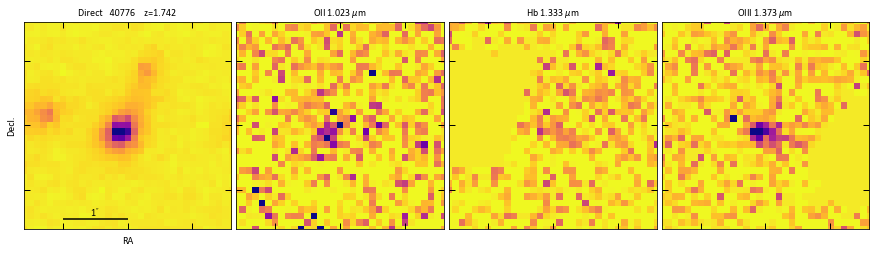

In [13]:
# Show the drizzled lines
from imp import reload
reload(grizli.fitting)
fig = grizli.fitting.show_drizzled_lines(line_hdu, size_arcsec=1.6, cmap='plasma_r')
fig.savefig('{0}_{1:05d}.line.png'.format(TARGET, id))